# Import Libraries

In [1]:
# Pandas and numpy for data wrangling
from mpl_toolkits.mplot3d import axes3d
from scipy import stats
import pandas as pd
import numpy as np

# Seaborn / matplotlib for visualization 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Import the trees from sklearn
from sklearn import tree

# Helper function to split our data
from sklearn.model_selection import train_test_split

# Helper fuctions to evaluate our model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score 

# Helper function for hyper-parameter turning.
from sklearn.model_selection import GridSearchCV

# Import our Decision Tree
from sklearn.tree import DecisionTreeClassifier 

# Import our Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Library for visualizing our tree
# If you get an error, run 'conda install python-graphviz' in your terminal
import graphviz 
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('data/cumulative.csv')
#df.set_index("rowid", inplace = True)
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [3]:
# Composition of Classifications
agg_fxns = {
    'koi_disposition': ['count'],
    'koi_score': ['mean']
}
df.groupby(['koi_disposition']).agg(agg_fxns)

,koi_disposition,koi_score
,count,mean
koi_disposition,,
CANDIDATE,2248,0.900210
CONFIRMED,2293,0.962597
FALSE POSITIVE,5023,0.014899


In [4]:
agg_fxns = {
    'koi_pdisposition': ['count'],
    'koi_score': ['mean']
}
df.groupby(['koi_pdisposition']).agg(agg_fxns)

,koi_pdisposition,koi_score
,count,mean
koi_pdisposition,,
CANDIDATE,4496,0.944312
FALSE POSITIVE,5068,0.015733


# Exploratory Data analysis

In [5]:
pd.options.display.max_columns = 6

In [6]:
df.describe()

,rowid,kepid,koi_score,...,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,...,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,...,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,...,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,...,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,...,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,...,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,...,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,...,301.720760,52.336010,20.003000


In [7]:
#printing the shape of our df
df.shape

(9564, 50)

<AxesSubplot:>

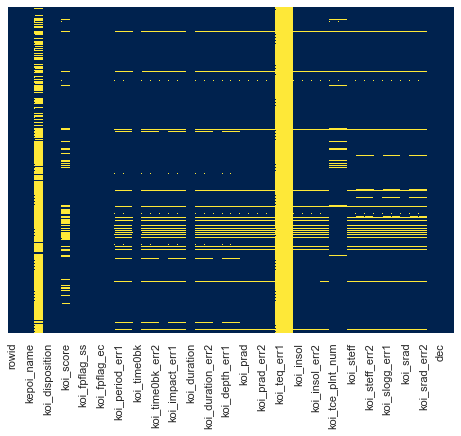

In [8]:
#Using Seaborn to create a heatpmap to see where our missing data is.
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='cividis')

<AxesSubplot:xlabel='koi_disposition', ylabel='count'>

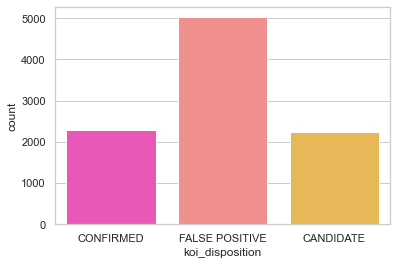

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='koi_disposition', data=df, palette='spring')

<AxesSubplot:xlabel='koi_disposition', ylabel='count'>

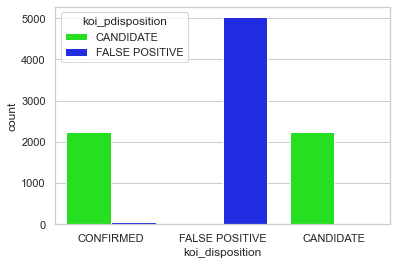

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='koi_disposition',hue='koi_pdisposition', data=df, palette='hsv')

In [11]:
#Replace the enumerated values in the df
df = df.replace({'CONFIRMED': 0, 'CANDIDATE': 1, 'FALSE POSITIVE': 2})

In [12]:
# Clean the Data Frame by removing all labels, and error values
df = df.drop([ 'kepid', 'kepoi_name', 'kepler_name', 'koi_tce_delivname', 
                     'koi_period_err1', 'koi_period_err2', 
                     'koi_time0bk_err1', 'koi_time0bk_err2', 
                     'koi_impact_err1', 'koi_impact_err2',
                     'koi_depth_err1', 'koi_depth_err2', 
                     'koi_prad_err1', 'koi_prad_err2', 
                     'koi_insol_err1', 'koi_insol_err2',
                     'koi_steff_err1', 'koi_steff_err2', 
                     'koi_slogg_err1', 'koi_slogg_err2', 
                     'koi_srad_err1', 'koi_srad_err2', 
                     'koi_duration_err1', 'koi_duration_err2', 
                     'koi_teq_err1', 'koi_teq_err2'], axis=1)

In [13]:
# Filling null values 
df.fillna(df.mean(), inplace=True)
#df.fillna(value = 0, inplace = True)
df

,rowid,koi_disposition,koi_pdisposition,...,ra,dec,koi_kepmag
0,1,0,1,...,291.93423,48.141651,15.347
1,2,0,1,...,291.93423,48.141651,15.347
2,3,2,2,...,297.00482,48.134129,15.436
3,4,2,2,...,285.53461,48.285210,15.597
4,5,0,1,...,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...
9559,9560,2,2,...,298.74921,46.973351,14.478
9560,9561,2,2,...,297.18875,47.093819,14.082
9561,9562,1,1,...,286.50937,47.163219,14.757
9562,9563,2,2,...,294.16489,47.176281,15.385


In [14]:
#Checking for missing values
df.isnull().sum() 

rowid               0
koi_disposition     0
koi_pdisposition    0
koi_score           0
koi_fpflag_nt       0
koi_fpflag_ss       0
koi_fpflag_co       0
koi_fpflag_ec       0
koi_period          0
koi_time0bk         0
koi_impact          0
koi_duration        0
koi_depth           0
koi_prad            0
koi_teq             0
koi_insol           0
koi_model_snr       0
koi_tce_plnt_num    0
koi_steff           0
koi_slogg           0
koi_srad            0
ra                  0
dec                 0
koi_kepmag          0
dtype: int64

In [15]:
# Check for Duplicates
df.duplicated().sum()

0

<AxesSubplot:>

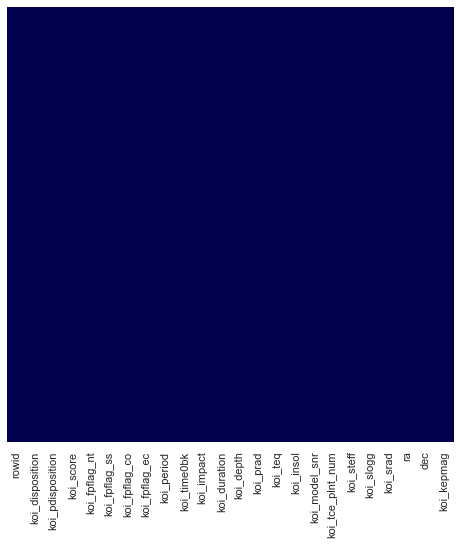

In [16]:
#Using this heatmap for sanity check
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='seismic')

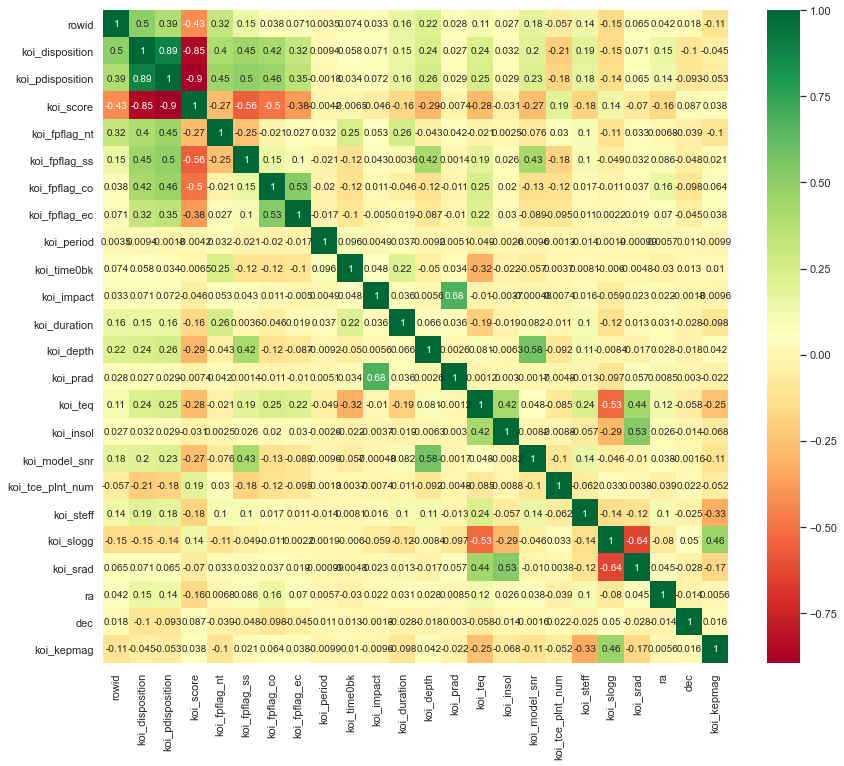

In [17]:
#Correlation matrix of the dataset for all KOIs common attributes
plt.figure(figsize=(14,12))

ax = sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
#axs[0].set_title("Frequency of KOIS")



In [18]:
class visualizer:
    def __init__(self, df, colname, fields, dimensions, figsize=None):
        self.df = df
        self.colname = colname
        self.fields = fields
        self.figsz = figsize
        self.dim = dimensions
        
    def data(self, field):
        vals = list(set(self.df[self.colname]))
        return [self.df[self.df[self.colname] == i][field].values for i in vals]
          
    def plot(self, ax, field):
        ax.set_title(field)
        ax.set_xlabel("Classification")
        sns.boxplot(ax=ax, data = self.data(field), showfliers=False)
    
    def graph(self):
        fig, axes = plt.subplots(nrows=self.dim[0], ncols=self.dim[1], figsize=self.figsz)
        for ax, field in zip(axes.reshape(-1), self.fields):
            self.plot(ax, field)
                       

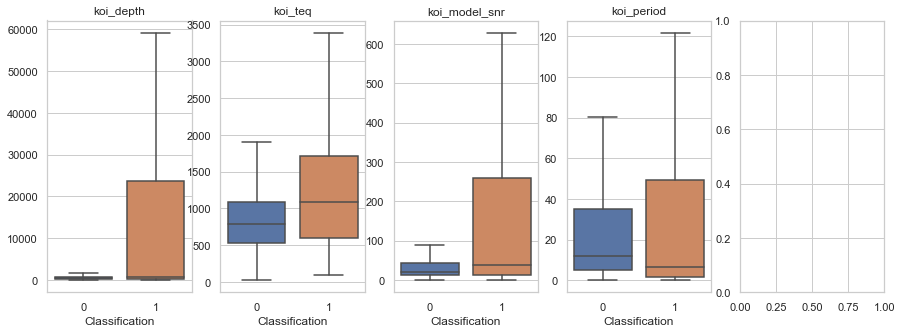

In [26]:
fields = ['koi_depth', 'koi_teq', 'koi_model_snr', 'koi_period']
id = 'koi_pdisposition'

v = visualizer(df, 'koi_pdisposition', fields, (1,5), (15,5))
v.graph()

In [20]:
features = ['koi_teq', 'koi_model_snr', 'koi_duration','koi_impact','koi_depth']


In [21]:
target = ['koi_pdisposition'] 
#Define your X and y variables
X = df[features].values
y = df[target].values

In [22]:
#Splitting our training and testing data
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3, random_state=45)
print('Lenght of our Training data:', X_train.shape, '\nLength of our Testing data:', y_test.shape)

Lenght of our Training data: (6694, 5) 
Length of our Testing data: (2870, 1)


In [23]:
model = DecisionTreeClassifier(max_depth=8)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [24]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)

#pd.crosstab(y_test, y_pred)

Accuracy Score: 0.788850
Precision Score: 0.786873
Recall Score: 0.770954
F1 Score: 0.778832


In [25]:
# using SMOTE for imbalance data
# from collections import Counter
# from imblearn.over_sampling  import SMOTE
# smote = SMOTE()

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
X_train_smote, y_train_smote = smote.fit_sample(X_train.astype('float'), y_train)
print("Before SMOTE:",(y_train))
print("After SMOTE", (y_train_smote))

In [ ]:
model.fit(X_train_smote,y_train_smote)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)
#pd.crosstab(y_test, y_pred)

In [ ]:
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=features,
                     class_names=['CONFIRMED','CANDIDATE'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph;

In [ ]:
 #Make a dictionary of at least 3 parameters and a list of 3 values for each for your grid search.from sklearn.model_selection import GridSearchCV
params = { 
    'criterion' : ['gini', 'entropy'],
    'max_depth': [5, 7, 9], 
    'min_samples_split': [2, 4, 6 ]
     }

In [ ]:
#Initalize the GridSearchCV with a DecisionTreeClassifierizing for. 
grid_search_cv =  GridSearchCV( 
    estimator = DecisionTreeClassifier(), 
    param_grid = params, 
    scoring = 'roc_auc')

In [ ]:
#Fitting GridSearchCV with the training data. 
grid_search_cv.fit(X_train, y_train)


In [ ]:
# Print the best parameters
print(grid_search_cv.best_params_)

In [ ]:
model = grid_search_cv.best_estimator_

# let's evaluate our model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)



In [ ]:
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=features,
                       class_names=['CONFIRMED','CANDIDATE'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

# Random forest Model


In [27]:
# Initialize our empty Random Forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train,  np.ravel(y_train))

# Evaluate our model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy Score: %f" % accuracy)

precision = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision Score: %f" % precision)

recall = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall Score: %f" % recall)

f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 Score: %f' % f1)

# Calculate predicted probabilities, keep only probability for when class = 1
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
print('AUC Score: %f' % auc)

Accuracy Score: 0.800000
Precision Score: 0.788051
Recall Score: 0.800578
F1 Score: 0.794265
AUC Score: 0.881233
